# Locally Linear Embedding (LLE)

- Non-linear
- Preserve the neighbourhood relations in the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

n_points = 2000
data, color = datasets.samples_generator.make_swiss_roll(n_points,0.01, random_state=0)

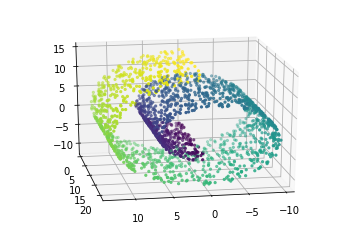

In [2]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color,marker='.')
ax.view_init(20, 80)
plt.show()

## The Locally Linear Embedding Algorithm

- Decide on the neighbours of each point

In [3]:
K = 10
nRedDim=2

ndata = np.shape(data)[0]
ndim = np.shape(data)[1]
d = np.zeros((ndata,ndata),dtype=float)

- compute distances between every pair of points
- find the k smallest distances
- set $W_{ij} = 0$ for other points

In [4]:
# Inefficient -- not matrices
for i in range(ndata):
	for j in range(i+1,ndata):
		for k in range(ndim):
			d[i,j] += (data[i,k] - data[j,k])**2
		d[i,j] = np.sqrt(d[i,j])
		d[j,i] = d[i,j]
        
indices = d.argsort(axis=1)
neighbours = indices[:,1:K+1]

W = np.zeros((K,ndata),dtype=float)
print d.shape

(2000, 2000)


- for each point $x_i$ :
    - create a list of its neighbours’ locations $z_i$
    - compute $z_i = z_i - x_i$
- Compute the weights matrix $W$ that minimises equation according to the constraints:
    - compute local covariance $C = ZZ^T$ , where $Z$ is the matrix of $z_is$
    - solve $CW = I$ for $W$, where $I$ is the $N \times N$ identity matrix
    - set $W_{ij} = 0$ for non-neighbours
    - set other elements to $W/ \sum(W)$


In [5]:
# np.kron(),takes two matrices and multiplies each element of the 
# first one by all the elements of the second, putting all of the results 
# together into one multi-dimensional output array.
for i in range(ndata):
	Z  = data[neighbours[i,:],:] - np.kron(np.ones((K,1)),data[i,:])
	C = np.dot(Z,np.transpose(Z))
	C = C+np.identity(K)*1e-3*np.trace(C)
	W[:,i] = np.transpose(np.linalg.solve(C,np.ones((K,1))))
	W[:,i] = W[:,i]/np.sum(W[:,i])

- Compute the lower dimensional vectors $y_i$ that minimise Equation (6.32):
    - create $M = (I - W) T (I - W)$
    - compute the eigenvalues and eigenvectors of $M$
    - sort the eigenvectors into order by size of eigenvalue
    - set the $q$th row of y to be the $q + 1$ eigenvector corresponding to the $q$th smallest eigenvalue (ignore the first eigenvector, which has eigenvalue $0$)

In [6]:
M = np.eye(ndata,dtype=float)
for i in range(ndata):
	w = np.transpose(np.ones((1,np.shape(W)[0]))*np.transpose(W[:,i]))
	j = neighbours[i,:]
	#print shape(w), np.shape(np.dot(w,np.transpose(w))), np.shape(M[i,j])
	ww = np.dot(w,np.transpose(w))
	for k in range(K):
		M[i,j[k]] -= w[k]
		M[j[k],i] -= w[k]
		for l in range(K):
		     M[j[k],j[l]] += ww[k,l]

evals,evecs = np.linalg.eig(M)
ind = np.argsort(evals)
y = evecs[:,ind[1:nRedDim+1]]*np.sqrt(ndata)

In [7]:
y.shape

(2000, 2)

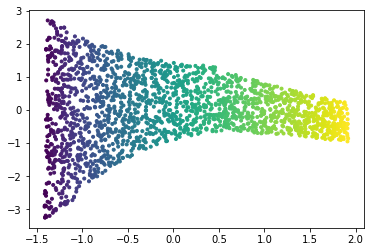

In [8]:
trans_data = y
plt.scatter(trans_data[:, 0], trans_data[:, 1], c=color, marker='.')
plt.show()

In [9]:
from sklearn.manifold import LocallyLinearEmbedding

embedding = LocallyLinearEmbedding(K,  n_components=nRedDim, reg=1e-3)
X_lle = embedding.fit_transform(data)

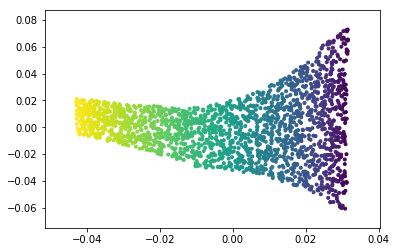

In [10]:
plt.scatter(X_lle[:, 0], X_lle[:, 1], c=color, marker='.')
plt.show()

In [11]:
def subplot_raw(data, names=None):
    fig, axs = plt.subplots(1, len(data), figsize=(13, 3))

    for a, d in zip(range(0,len(data)), data):
        axs[a].scatter(d[:, 0], d[:, 1], c=color, marker='.')
        if names:
            axs[a].set_title(names[a])
        


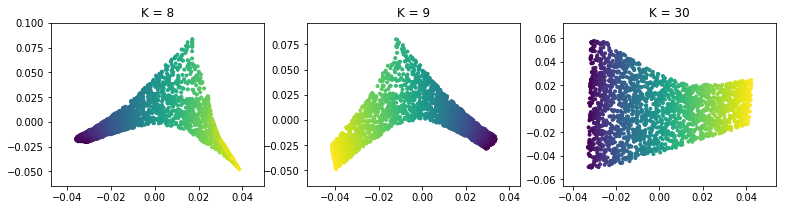

In [12]:
embedding = LocallyLinearEmbedding(8,  n_components=nRedDim, reg=1e-3)
X_lle1 = embedding.fit_transform(data)

embedding = LocallyLinearEmbedding(9,  n_components=nRedDim, reg=1e-3)
X_lle2 = embedding.fit_transform(data)

embedding = LocallyLinearEmbedding(30,  n_components=nRedDim, reg=1e-3)
X_lle3 = embedding.fit_transform(data)
new_data = [X_lle1, X_lle2, X_lle3]
names = ['K = 8', 'K = 9', 'K = 30']
subplot_raw(new_data, names)

## Real Dataset

In [17]:
from sklearn.manifold import LocallyLinearEmbedding
iris = datasets.load_iris()
target_ids = np.unique(iris.target)
K = 25
y = iris.target

In [18]:
def subplot_rawl(data, names=None):
    labels = iris.target
    fig, axs = plt.subplots(1, len(data), figsize=(12, 5))
    colors = ['turquoise', 'navy', 'darkorange']


    for a, d in zip(range(0,len(data)), data):
        for i, c, label in zip(target_ids, colors,iris.target_names):
            axs[a].scatter(d[i == labels, 0], d[i == labels, 1], c = c, edgecolors='black', s=250,label=label, marker='.')
            axs[a].legend()
        if names:
            axs[a].set_title(names[a])

In [19]:
from sklearn.manifold import LocallyLinearEmbedding

embedding = LocallyLinearEmbedding(K,  n_components=nRedDim, reg=1e-3)
X_lle1 = embedding.fit_transform(iris.data)


embedding = LocallyLinearEmbedding(50,  n_components=nRedDim, reg=1e-3)
X_lle2 = embedding.fit_transform(iris.data)


embedding = LocallyLinearEmbedding(70,  n_components=nRedDim, reg=1e-3)
X_lle3 = embedding.fit_transform(iris.data)


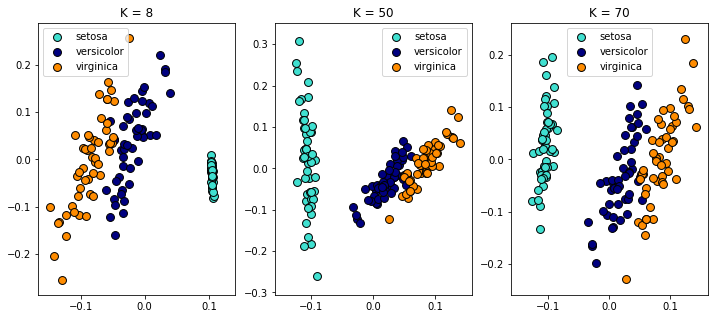

In [20]:
new_data2 = [X_lle1, X_lle2, X_lle3]
names = ['K = 8', 'K = 50', 'K = 70']
subplot_rawl(new_data2, names)

## References
[
Machine Learning: An Algorithmic Perspective: Stephen Marsland ](http://dai.fmph.uniba.sk/courses/ICI/References/marsland.machine-learning.2ed.2015.pdf)